# FROZEN PRODUCT AMOUNT FORECAST BY TIME

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.
**************************
## Veri

Bu veri seti hakkında bilgi: https://fred.stlouisfed.org/series/IPN31152N


Birimler: Endeks 2012=100, Mevsimsellikten Arındırılmamış

Sıklık: Aylık

Sanayi üretimi (IP) endeksi, mülkiyetlerine bakılmaksızın Amerika Birleşik Devletleri'nde yerleşik tüm ilgili kuruluşların gerçek çıktısını ölçer, ancak ABD topraklarında bulunanları değil.

NAICS = 31152

Kaynak Kodu: IP.N31152.N

Önerilen Atıf:
Federal Rezerv Sistemi (ABD) Guvernörler Kurulu, Endüstriyel Üretim: Dayanıksız Mallar: Dondurma ve dondurulmuş tatlı [IPN31152N], FRED'den alındı, St. Louis Federal Rezerv Bankası; https://fred.stlouisfed.org/series/IPN31152N, 16 Kasım 2019.

# 1. Libraries|User Defined Functions

## 1.1. Import Libraries

In [1]:
# !pip install pyforest
# 1-Import Libraies
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno 

from sklearn.compose import make_column_transformer

# Scaling
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


# Importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Figure&Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# !pip install termcolor
import colorama
from colorama import Fore, Style  # maakes strings colored
from termcolor import colored

import ipywidgets
from ipywidgets import interact

## 1.2. Some Useful User Defined Functions

In [2]:
## Some Useful Functions

###############################################################################

def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

###############################################################################

def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('-'*79, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    
        
def multicolinearity_control(df):
    feature =[]
    collinear=[]
    for col in df.corr().columns:
        for i in df.corr().index:
            if (abs(df.corr()[col][i])> .9 and abs(df.corr()[col][i]) < 1):
                    feature.append(col)
                    collinear.append(i)
                    print(colored(f"Multicolinearity alert in between:{col} - {i}", 
                                  "red", attrs=['bold']), df.shape,'\n',
                                  colored('-'*79, 'red', attrs=['bold']), sep='')

def duplicate_values(df):
    print(colored("Duplicate check...", attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored("Duplicates were dropped!"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There are no duplicates"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')     
        
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('We will now check the missing values and if necessary will drop realted columns!', attrs=['bold']),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
        
def drop_null(df, limit):
    print('Shape:', df.shape)
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'null and were dropped')
            df.drop(i, axis=1, inplace=True)
            print('new shape:', df.shape)       
    print('New shape after missing value control:', df.shape)
    
###############################################################################

# 2. Read dataset

In [3]:
df0 = pd.read_csv("Frozen_Dessert_Production.csv",
                   index_col='DATE',
                   parse_dates=True)
df = df0.copy()
df.head()
first_looking(df)
duplicate_values(df)
drop_columns(df,[])
drop_null(df, 90)
# df.head()
# df.describe().T
# df.describe(include=object).T

Shape:(573, 1)
-------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB
None
-------------------------------------------------------------------------------
Number of Uniques:
IPN31152N    573
dtype: int64
-------------------------------------------------------------------------------
Missing Values:
Empty DataFrame
Columns: [Missing_Number, Missing_Percent]
Index: []
-------------------------------------------------------------------------------
All Columns:['IPN31152N']
-------------------------------------------------------------------------------
Columns after rename:['ipn31152n']
-------------------------------------------------------------------------------
Duplicate check

In [4]:
df = df.rename(columns={'ipn31152n':'amount'})

In [5]:
df.head()

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [6]:
df.tail()

,amount
DATE,
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263
2019-08-01,102.609
2019-09-01,101.587


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
amount,573.000,109.896,27.951,58.660,88.936,107.643,128.278,196.174


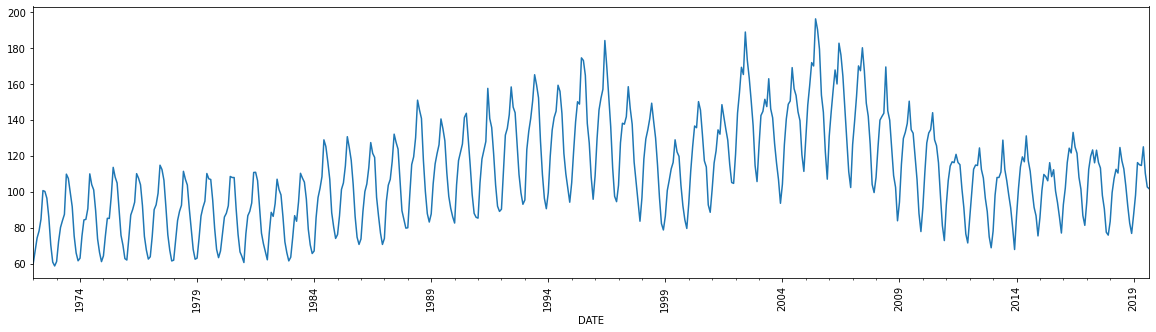

In [8]:
df['amount'].plot(figsize=(20,5))
plt.xticks(rotation=90);

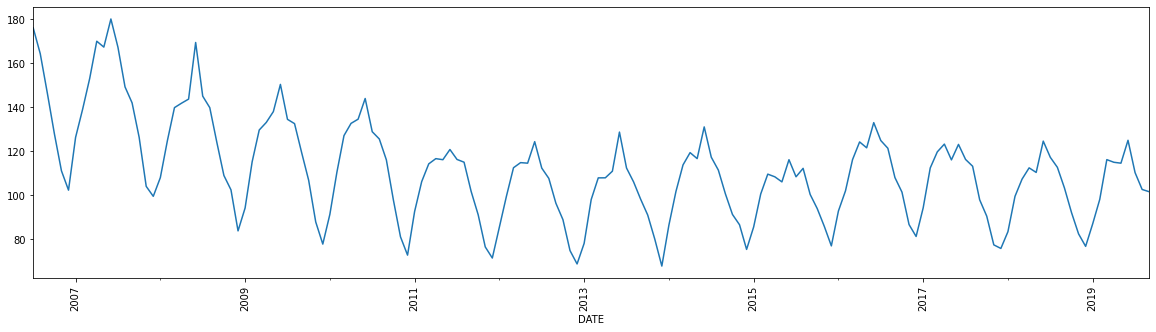

In [9]:
df['amount'].loc["2006-06-30" : "2019-09-01"].plot(figsize=(20,5))
plt.xticks(rotation=90);

### 3. Check missing values

In [10]:
missing_values(df)

,Missing_Number,Missing_Percent


### 4. Plot the distribution of various discrete features on (Season, haliday, weekend and weathercode)

In [11]:
df.head()

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [12]:
df_ = df.copy()
df_["year"] = df_.index.year
df_['month'] = df_.index.month 
df_.head()

,amount,year,month
DATE,,,
1972-01-01,59.962,1972,1
1972-02-01,67.061,1972,2
1972-03-01,74.235,1972,3
1972-04-01,78.112,1972,4
1972-05-01,84.764,1972,5


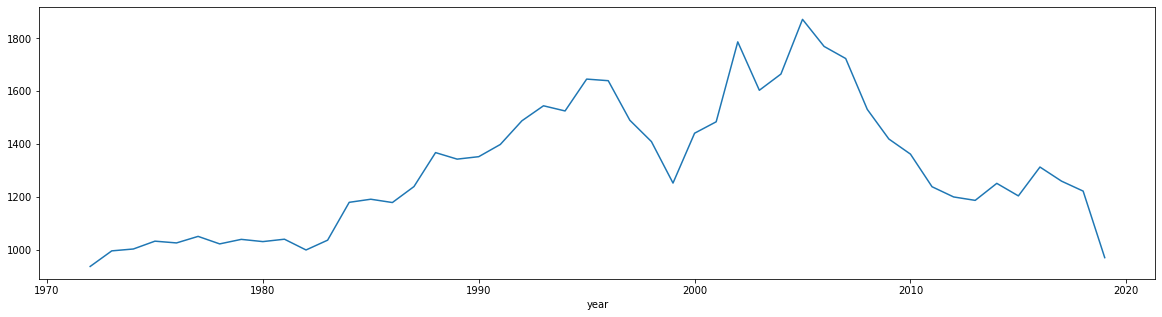

In [13]:
yearly_total_amount = df_.groupby("year")["amount"].sum()
plt.figure(figsize=(20,5))
sns.lineplot(yearly_total_amount.index, yearly_total_amount.values);

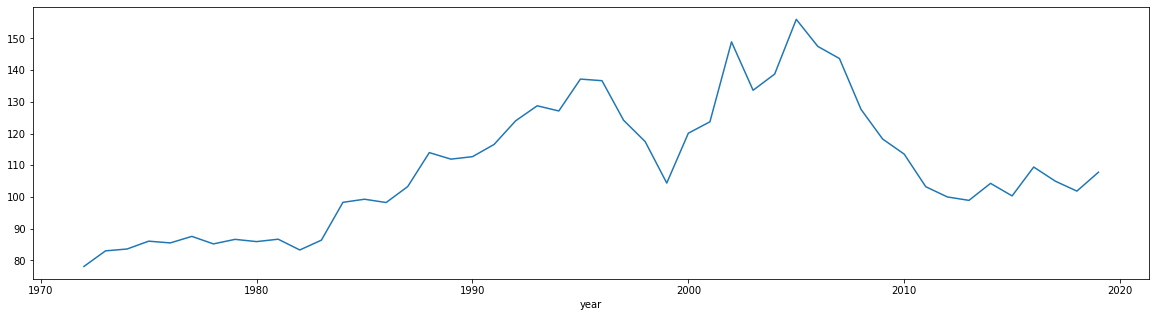

In [14]:
yearly_avg_amount = df_.groupby("year")["amount"].mean()
plt.figure(figsize=(20,5))
sns.lineplot(yearly_avg_amount.index, yearly_avg_amount.values);

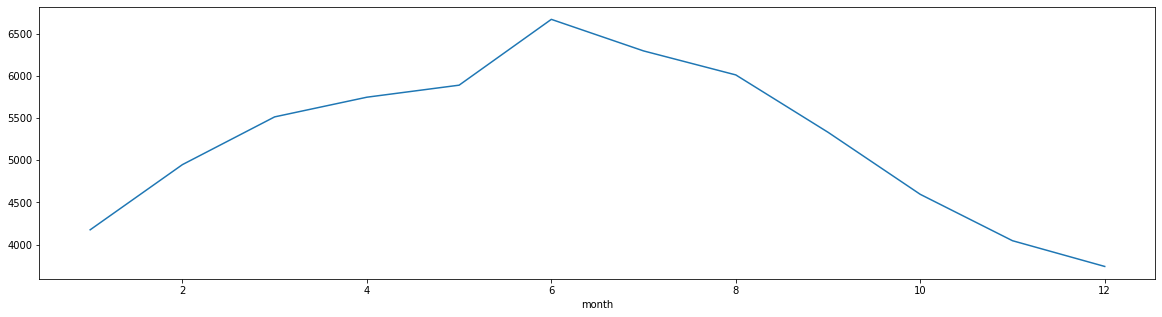

In [15]:
monthly_total_amount = df_.groupby("month")["amount"].sum()
plt.figure(figsize=(20,5))
sns.lineplot(monthly_total_amount.index, monthly_total_amount.values);

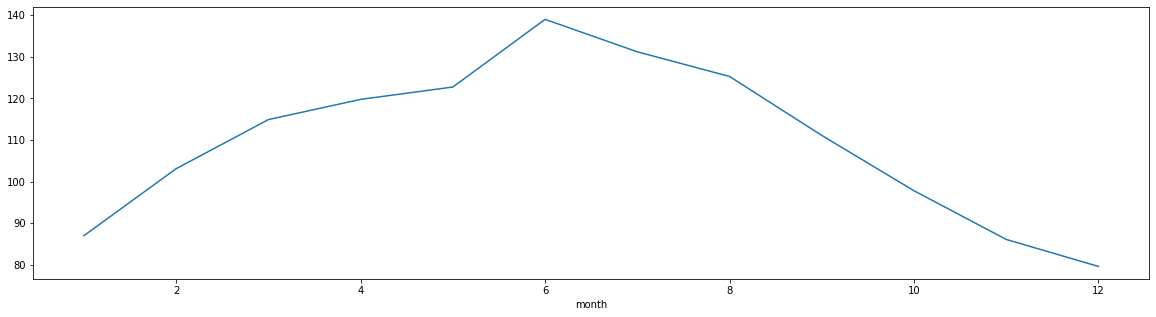

In [16]:
monthly_avg_amount = df_.groupby("month")["amount"].mean()
plt.figure(figsize=(20,5))
sns.lineplot(monthly_avg_amount.index, monthly_avg_amount.values);

### 5. Preprocessing of Data

### Train Test Split

In [17]:
len(df)

573

In [18]:
test_size = int(len(df)*0.15)

In [19]:
test_ind = len(df)- test_size
test_ind 

488

In [20]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [21]:
train.head()

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [22]:
test.head()

,amount
DATE,
2012-09-01,96.370
2012-10-01,88.886
2012-11-01,74.838
2012-12-01,68.769
2013-01-01,78.118


### Scaling

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
scaler = StandardScaler()

In [25]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

### Time Series Generator

In [26]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [27]:
length = 24
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

In [28]:
generator[0]

(array([[[-1.74282909],
         [-1.50107292],
         [-1.2567215 ],
         [-1.12467739],
         [-0.89813507],
         [-0.35891012],
         [-0.37490731],
         [-0.50315732],
         [-0.86281318],
         [-1.38755994],
         [-1.71404981],
         [-1.78718665],
         [-1.70409116],
         [-1.32581902],
         [-1.05702394],
         [-0.92734689],
         [-0.80932459],
         [-0.04725265],
         [-0.12803558],
         [-0.39068312],
         [-0.66437238],
         [-1.2202825 ],
         [-1.5394328 ],
         [-1.68941883]]]),
 array([[-1.64006152]]))

In [29]:
train_scaled[0:25]

array([[-1.74282909],
       [-1.50107292],
       [-1.2567215 ],
       [-1.12467739],
       [-0.89813507],
       [-0.35891012],
       [-0.37490731],
       [-0.50315732],
       [-0.86281318],
       [-1.38755994],
       [-1.71404981],
       [-1.78718665],
       [-1.70409116],
       [-1.32581902],
       [-1.05702394],
       [-0.92734689],
       [-0.80932459],
       [-0.04725265],
       [-0.12803558],
       [-0.39068312],
       [-0.66437238],
       [-1.2202825 ],
       [-1.5394328 ],
       [-1.68941883],
       [-1.64006152]])

In [30]:
X, y = generator[0]

In [31]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-1.74282909 -1.50107292 -1.2567215  -1.12467739 -0.89813507 -0.35891012
 -0.37490731 -0.50315732 -0.86281318 -1.38755994 -1.71404981 -1.78718665
 -1.70409116 -1.32581902 -1.05702394 -0.92734689 -0.80932459 -0.04725265
 -0.12803558 -0.39068312 -0.66437238 -1.2202825  -1.5394328  -1.68941883]
Predict this y: 
 [[-1.64006152]]


## 6. Modelling & Model Performance

### Creating Model

### 6.1. With "tanh" activation function

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.layers import Dropout

In [49]:
n_features = 1

In [55]:
model = Sequential()
model.add(LSTM(72, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [56]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 72)                21312     
                                                                 
 dense_1 (Dense)             (None, 1)                 73        
                                                                 
Total params: 21,385
Trainable params: 21,385
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

In [57]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 12)

In [58]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [59]:
len(validation_generator)

61

In [60]:
model.fit_generator(generator, epochs = 64,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/64
464/464 [==============================] - 8s 12ms/step - loss: 0.3087 - val_loss: 0.0503
Epoch 2/64
464/464 [==============================] - 5s 10ms/step - loss: 0.0792 - val_loss: 0.0868
Epoch 3/64
464/464 [==============================] - 5s 10ms/step - loss: 0.0591 - val_loss: 0.0495
Epoch 4/64
464/464 [==============================] - 5s 10ms/step - loss: 0.0582 - val_loss: 0.0711
Epoch 5/64
464/464 [==============================] - 5s 10ms/step - loss: 0.0576 - val_loss: 0.0430
Epoch 6/64
464/464 [==============================] - 5s 10ms/step - loss: 0.0513 - val_loss: 0.0537
Epoch 7/64
464/464 [==============================] - 5s 10ms/step - loss: 0.0481 - val_loss: 0.0631
Epoch 8/64
464/464 [==============================] - 5s 10ms/step - loss: 0.0465 - val_loss: 0.0460
Epoch 9/64
464/464 [==============================] - 5s 10ms/step - loss: 0.0430 - val_loss: 0.0438
Epoch 10/64
464/464 [==============================] - 5s 10ms/step - loss: 0.0413 - val_lo

<AxesSubplot:>

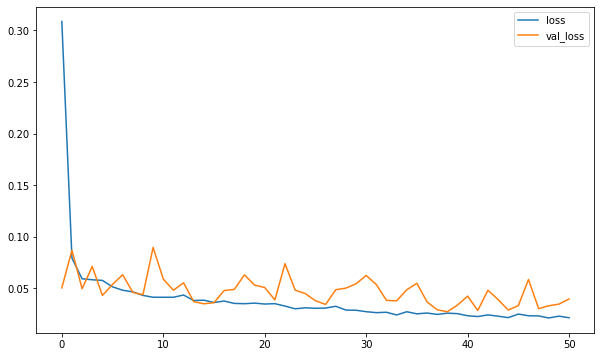

In [61]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [63]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [64]:
validation_generator[0]

(array([[[-0.50284058],
         [-0.75771942],
         [-1.23620136],
         [-1.44288087],
         [-1.12449007],
         [-0.44616413],
         [-0.1107033 ],
         [-0.10981437],
         [-0.00753043],
         [ 0.59795498],
         [ 0.0420653 ],
         [-0.17299937],
         [-0.44081357],
         [-0.68579506],
         [-1.05801163],
         [-1.47578121],
         [-0.84248718],
         [-0.32026074],
         [ 0.08996492],
         [ 0.27993201],
         [ 0.18720824],
         [ 0.67795117],
         [ 0.20904984],
         [ 0.00966902]]]),
 array([[-0.35818127]]))

In [65]:
len(validation_generator)

61

In [66]:
validation_generator[47]

(array([[[ 0.34732662],
         [-0.10551962],
         [-0.33208578],
         [-0.83338679],
         [-1.01756738],
         [-0.57520089],
         [ 0.04270219],
         [ 0.29167873],
         [ 0.4119046 ],
         [ 0.16788695],
         [ 0.40709556],
         [ 0.17471224],
         [ 0.0693971 ],
         [-0.45030562],
         [-0.70367568],
         [-1.14763951],
         [-1.20301834],
         [-0.94340879],
         [-0.39658203],
         [-0.13006545],
         [ 0.0441667 ],
         [-0.0265554 ],
         [ 0.45808427],
         [ 0.20732649]]]),
 array([[0.0525791]]))

In [67]:
y_pred = model.predict(validation_generator)
y_pred

61/61 [==============================] - 1s 3ms/step


array([[-0.5395584 ],
       [-0.7800071 ],
       [-0.9893465 ],
       [-1.0355117 ],
       [-1.0505744 ],
       [-0.30659303],
       [-0.05809198],
       [ 0.10649526],
       [ 0.23915635],
       [ 0.37370533],
       [-0.09520708],
       [-0.27002963],
       [-0.44194248],
       [-0.7822777 ],
       [-0.93011487],
       [-1.1348327 ],
       [-1.0426317 ],
       [-0.0751819 ],
       [ 0.09442142],
       [ 0.37690133],
       [ 0.6803175 ],
       [ 0.9530293 ],
       [ 0.435764  ],
       [ 0.21923026],
       [-0.17063919],
       [-0.5168363 ],
       [-0.64438593],
       [-1.0577148 ],
       [-0.70598114],
       [-0.02196112],
       [ 0.30532312],
       [ 0.39163035],
       [ 0.8488344 ],
       [ 0.56637037],
       [ 0.06937824],
       [-0.02215001],
       [-0.34246254],
       [-0.80670655],
       [-0.9790001 ],
       [-1.3190101 ],
       [-0.8583541 ],
       [-0.46440086],
       [-0.16238694],
       [-0.02809528],
       [ 0.37671095],
       [ 0

In [68]:
len(y_pred)

61

In [69]:
len(test_scaled)

85

In [70]:
len(test_scaled[24:])

61

In [71]:
test_scaled[24:]

array([[-0.35818127],
       [-0.67682751],
       [-0.83653378],
       [-1.21789842],
       [-0.87043543],
       [-0.36020433],
       [-0.05296763],
       [-0.09442342],
       [-0.17289379],
       [ 0.17041408],
       [-0.09388189],
       [ 0.03647973],
       [-0.36734636],
       [-0.58588498],
       [-0.86065729],
       [-1.16340511],
       [-0.62407117],
       [-0.31196753],
       [ 0.1718309 ],
       [ 0.44536349],
       [ 0.35452655],
       [ 0.7442559 ],
       [ 0.46718806],
       [ 0.34732662],
       [-0.10551962],
       [-0.33208578],
       [-0.83338679],
       [-1.01756738],
       [-0.57520089],
       [ 0.04270219],
       [ 0.29167873],
       [ 0.4119046 ],
       [ 0.16788695],
       [ 0.40709556],
       [ 0.17471224],
       [ 0.0693971 ],
       [-0.45030562],
       [-0.70367568],
       [-1.14763951],
       [-1.20301834],
       [-0.94340879],
       [-0.39658203],
       [-0.13006545],
       [ 0.0441667 ],
       [-0.0265554 ],
       [ 0

In [72]:
eval_metrics(test_scaled[24:], y_pred)

r2_score: 0.846026383486399 
 mae: 0.15344035981219276 
 mse: 0.039637150139522584 
 rmse: 0.199090808777107


In [73]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 [==============================] - 0s 26ms/step


In [74]:
eval_metrics(test_scaled, test_predictions)

r2_score: -1.7696753528929658 
 mae: 0.7105711901958113 
 mse: 0.7982251377063166 
 rmse: 0.893434461897635


#### Inverse Transformations and Comparing

In [75]:
true_predictions = scaler.inverse_transform(test_predictions)

In [76]:
test.head()

,amount
DATE,
2012-09-01,96.370
2012-10-01,88.886
2012-11-01,74.838
2012-12-01,68.769
2013-01-01,78.118


In [77]:
test['prediction'] = true_predictions

In [78]:
test.head()

,amount,prediction
DATE,,
2012-09-01,96.370,92.141
2012-10-01,88.886,80.531
2012-11-01,74.838,72.476
2012-12-01,68.769,68.314
2013-01-01,78.118,76.794


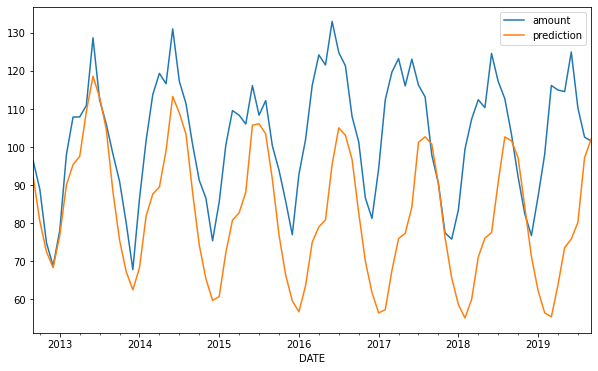

In [79]:
test.plot();

#### Calculation R2 Score and Error Metrics

In [80]:
eval_metrics(test.amount, test.prediction)

r2_score: -1.7696752821943673 
 mae: 20.863365459774244 
 mse: 688.1433852812133 
 rmse: 26.23248721111312


### 6.2. With "relu" activation function

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

n_features = 1
model = Sequential()

model.add(LSTM(56, activation = 'relu', input_shape = (length, n_features))) 
model.add(Dense(1)) 

model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 56)                12992     
                                                                 
 dense_2 (Dense)             (None, 1)                 57        
                                                                 
Total params: 13,049
Trainable params: 13,049
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [82]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)
len(validation_generator)

61

In [83]:
model.fit_generator(generator, epochs = 32,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/32
464/464 [==============================] - 6s 10ms/step - loss: 0.4795 - val_loss: 0.1598
Epoch 2/32
464/464 [==============================] - 4s 9ms/step - loss: 0.4995 - val_loss: 0.1897
Epoch 3/32
464/464 [==============================] - 4s 9ms/step - loss: 0.3616 - val_loss: 0.1739
Epoch 4/32
464/464 [==============================] - 4s 9ms/step - loss: 0.2308 - val_loss: 0.1003
Epoch 5/32
464/464 [==============================] - 4s 9ms/step - loss: 0.1724 - val_loss: 0.0748
Epoch 6/32
464/464 [==============================] - 4s 9ms/step - loss: 0.1045 - val_loss: 0.0763
Epoch 7/32
464/464 [==============================] - 4s 9ms/step - loss: 0.0926 - val_loss: 0.0562
Epoch 8/32
464/464 [==============================] - 4s 9ms/step - loss: 0.0831 - val_loss: 0.0526
Epoch 9/32
464/464 [==============================] - 4s 9ms/step - loss: 0.0726 - val_loss: 0.0508
Epoch 10/32
464/464 [==============================] - 4s 9ms/step - loss: 0.0675 - val_loss: 0.047

<AxesSubplot:>

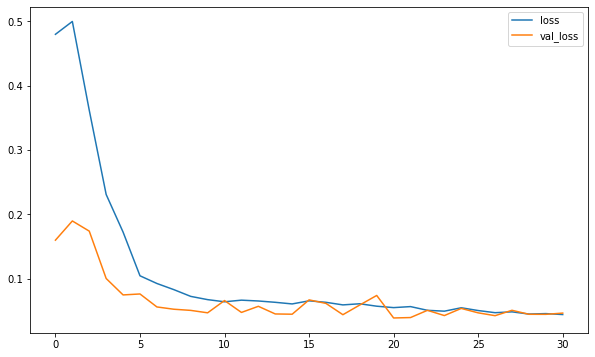

In [84]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [85]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [86]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [87]:
y_pred = model.predict(validation_generator)
y_pred

61/61 [==============================] - 0s 3ms/step


array([[-0.5640674 ],
       [-0.9248077 ],
       [-1.0898939 ],
       [-0.95508707],
       [-0.75142705],
       [-0.32426184],
       [ 0.02146417],
       [ 0.24616307],
       [ 0.25995162],
       [ 0.14676361],
       [ 0.01500087],
       [-0.3752092 ],
       [-0.53689444],
       [-0.8681383 ],
       [-1.0144997 ],
       [-1.0118502 ],
       [-0.7857088 ],
       [-0.16040817],
       [ 0.11766246],
       [ 0.4818185 ],
       [ 0.72914684],
       [ 0.63393956],
       [ 0.5151172 ],
       [ 0.09353262],
       [-0.23551843],
       [-0.6389415 ],
       [-0.7802458 ],
       [-0.87929493],
       [-0.53354913],
       [-0.01527152],
       [ 0.4156138 ],
       [ 0.62458366],
       [ 0.716792  ],
       [ 0.4583763 ],
       [ 0.21903808],
       [-0.12215786],
       [-0.426254  ],
       [-0.83746845],
       [-1.0005709 ],
       [-1.0392318 ],
       [-0.69385284],
       [-0.38644275],
       [-0.01607806],
       [ 0.21539342],
       [ 0.35768402],
       [ 0

In [88]:
test_scaled[24:]

array([[-0.35818127],
       [-0.67682751],
       [-0.83653378],
       [-1.21789842],
       [-0.87043543],
       [-0.36020433],
       [-0.05296763],
       [-0.09442342],
       [-0.17289379],
       [ 0.17041408],
       [-0.09388189],
       [ 0.03647973],
       [-0.36734636],
       [-0.58588498],
       [-0.86065729],
       [-1.16340511],
       [-0.62407117],
       [-0.31196753],
       [ 0.1718309 ],
       [ 0.44536349],
       [ 0.35452655],
       [ 0.7442559 ],
       [ 0.46718806],
       [ 0.34732662],
       [-0.10551962],
       [-0.33208578],
       [-0.83338679],
       [-1.01756738],
       [-0.57520089],
       [ 0.04270219],
       [ 0.29167873],
       [ 0.4119046 ],
       [ 0.16788695],
       [ 0.40709556],
       [ 0.17471224],
       [ 0.0693971 ],
       [-0.45030562],
       [-0.70367568],
       [-1.14763951],
       [-1.20301834],
       [-0.94340879],
       [-0.39658203],
       [-0.13006545],
       [ 0.0441667 ],
       [-0.0265554 ],
       [ 0

In [89]:
eval_metrics(test_scaled[24:], y_pred)

r2_score: 0.8189843315925133 
 mae: 0.1785577402857877 
 mse: 0.04659853674112929 
 rmse: 0.2158669422147108


In [90]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 [==============================] - 0s 26ms/step


In [91]:
eval_metrics(test_scaled, test_predictions)

r2_score: -0.207752970077149 
 mae: 0.48367053763149576 
 mse: 0.3480764559095606 
 rmse: 0.5899800470435933


#### Inverse Transformations and Comparing

In [92]:
true_predictions_relu = scaler.inverse_transform(test_predictions)

In [93]:
test['predictions_relu'] = true_predictions_relu

In [95]:
test.head()

,amount,prediction,predictions_relu
DATE,,,
2012-09-01,96.370,92.141,95.997
2012-10-01,88.886,80.531,82.541
2012-11-01,74.838,72.476,74.180
2012-12-01,68.769,68.314,76.957
2013-01-01,78.118,76.794,92.224


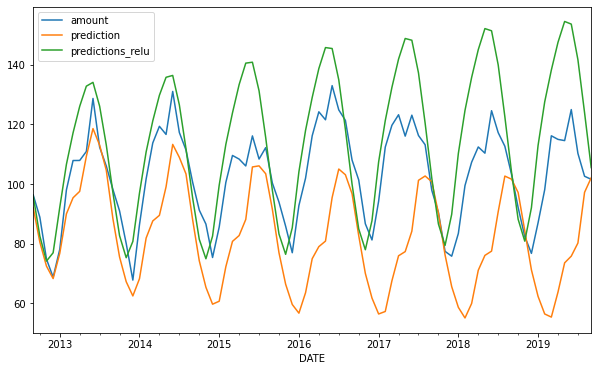

In [96]:
test.plot();

#### Calculation R2 Score and Error Metrics

In [97]:
eval_metrics(test.amount, test.predictions_relu)

r2_score: -0.2077528496908574 
 mae: 14.201243865894988 
 mse: 300.07385339079417 
 rmse: 17.322639908247073


## 7. Retrain and Forecasting

In [98]:
test

,amount,prediction,predictions_relu
DATE,,,
2012-09-01,96.370,92.141,95.997
2012-10-01,88.886,80.531,82.541
2012-11-01,74.838,72.476,74.180
2012-12-01,68.769,68.314,76.957
2013-01-01,78.118,76.794,92.224
2013-02-01,98.034,90.004,106.600
2013-03-01,107.884,95.394,117.171
2013-04-01,107.910,97.549,126.046
2013-05-01,110.913,109.288,132.805


In [99]:
full_scaler = StandardScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [100]:
length = 24 
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [101]:
model = Sequential()

model.add(LSTM(57, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=64)

Epoch 1/64
549/549 [==============================] - 8s 10ms/step - loss: 0.3500
Epoch 2/64
549/549 [==============================] - 5s 10ms/step - loss: 0.0884
Epoch 3/64
549/549 [==============================] - 5s 10ms/step - loss: 0.0666
Epoch 4/64
549/549 [==============================] - 5s 10ms/step - loss: 0.0638
Epoch 5/64
549/549 [==============================] - 5s 10ms/step - loss: 0.0579
Epoch 6/64
549/549 [==============================] - 5s 9ms/step - loss: 0.0585
Epoch 7/64
549/549 [==============================] - 5s 10ms/step - loss: 0.0514
Epoch 8/64
549/549 [==============================] - 6s 10ms/step - loss: 0.0497
Epoch 9/64
549/549 [==============================] - 5s 10ms/step - loss: 0.0466
Epoch 10/64
549/549 [==============================] - 5s 10ms/step - loss: 0.0484
Epoch 11/64
549/549 [==============================] - 5s 10ms/step - loss: 0.0440
Epoch 12/64
549/549 [==============================] - 5s 10ms/step - loss: 0.0397
Epoch 13/64
54

In [102]:
scaled_full_data.shape

(573, 1)

In [103]:
scaled_full_data[-length:].shape

(24, 1)

In [104]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 24

first_eval_batch = scaled_full_data[-length:] 
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

1/1 [==============================] - 0s 17ms/step


In [105]:
forecast = scaler.inverse_transform(forecast)

In [106]:
forecast

array([[ 89.989   ],
       [ 80.193344],
       [ 73.31989 ],
       [ 84.25162 ],
       [ 99.76256 ],
       [109.85988 ],
       [113.67788 ],
       [111.82272 ],
       [124.073456],
       [114.08891 ],
       [111.13717 ],
       [100.76459 ],
       [ 89.91403 ],
       [ 79.14902 ],
       [ 72.84326 ],
       [ 83.99056 ],
       [ 99.24131 ],
       [109.940094],
       [113.612015],
       [111.581474],
       [124.025536],
       [113.57653 ],
       [110.850555],
       [100.04258 ]], dtype=float32)

In [107]:
df.head()

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [108]:
forecast_index = pd.date_range(start = '2019-10-01', periods = periods, freq = 'MS')

In [109]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [110]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['forecast'])

In [111]:
forecast_df

,forecast
2019-10-01,89.989
2019-11-01,80.193
2019-12-01,73.320
2020-01-01,84.252
2020-02-01,99.763
2020-03-01,109.860
2020-04-01,113.678
2020-05-01,111.823
2020-06-01,124.073
2020-07-01,114.089


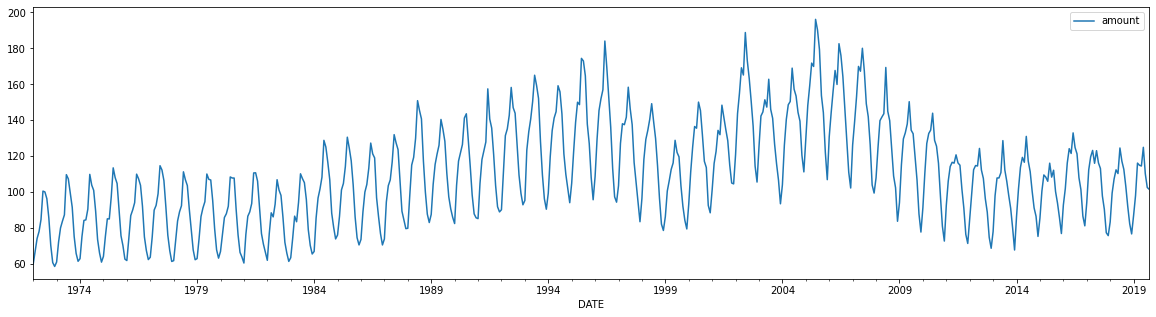

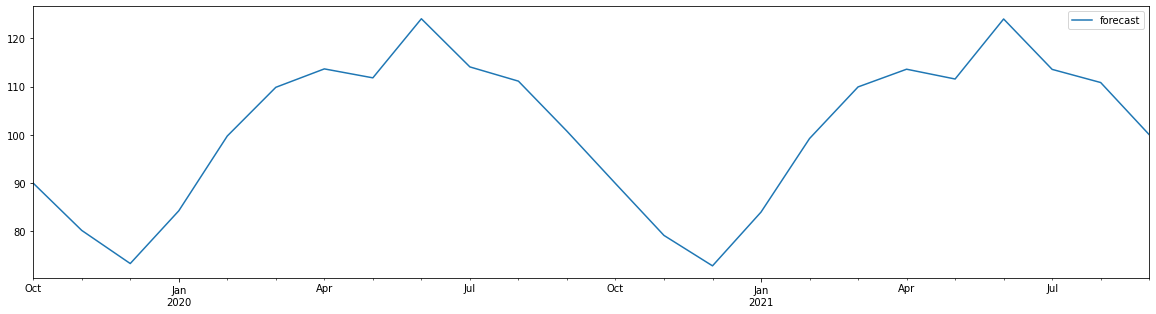

In [113]:
df.plot(figsize=(20,5));
forecast_df.plot(figsize=(20,5));

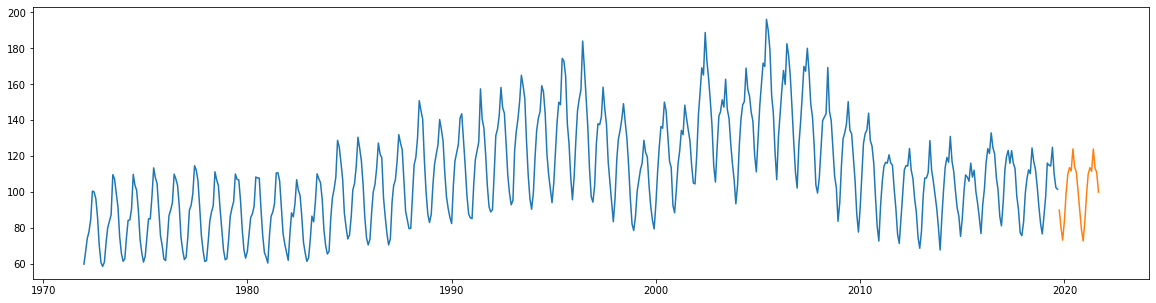

In [114]:
plt.figure(figsize = (20, 5))
plt.plot(df.index, df['amount'])
plt.plot(forecast_df.index, forecast_df['forecast']);
#plt.plot(forecast_index, forecast)

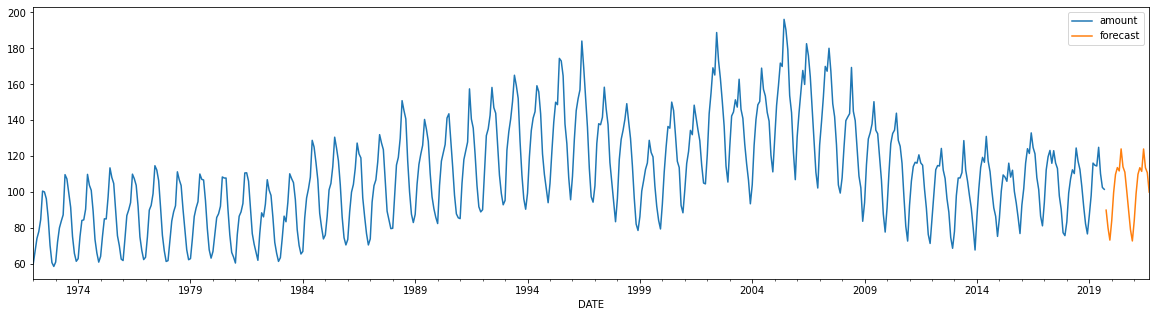

In [115]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (20, 5));

## Appx. Another approach: With actual human consuming behaviours in last 10 years

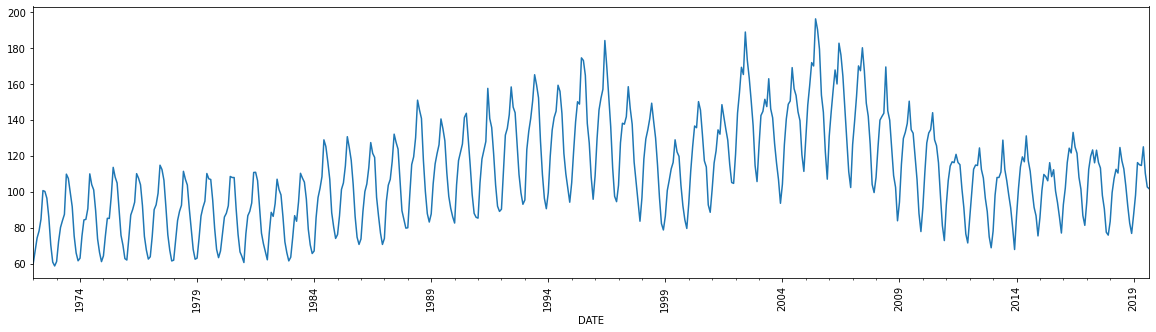

In [116]:
df['amount'].plot(figsize=(20,5))
plt.xticks(rotation=90);

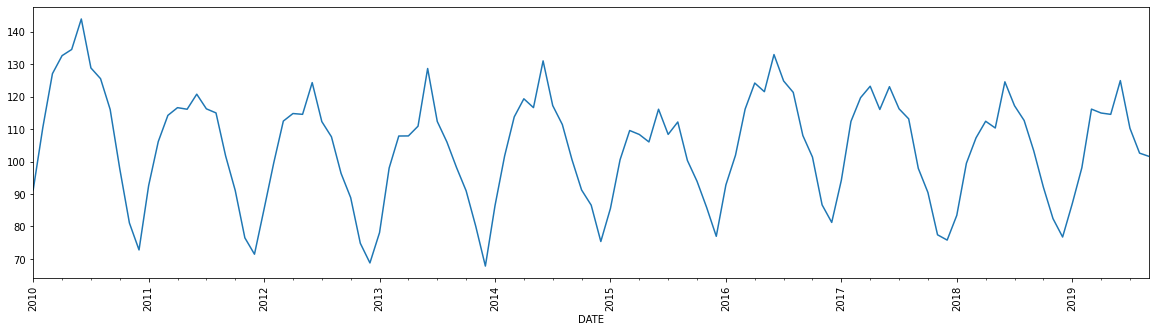

In [117]:
df['amount'].loc["2010-01-01" : "2019-09-01"].plot(figsize=(20,5))
plt.xticks(rotation=90);

In [118]:
df = df.loc["2010-01-01" : "2019-09-01"]
df.head()

,amount
DATE,
2010-01-01,91.290
2010-02-01,110.499
2010-03-01,127.097
2010-04-01,132.647
2010-05-01,134.558


### Preprocessing of Data

### Train Test Split

In [119]:
len(df)

117

In [120]:
test_size = 36

In [121]:
test_ind = len(df)- test_size
test_ind

81

In [122]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [123]:
train.head()

,amount
DATE,
2010-01-01,91.290
2010-02-01,110.499
2010-03-01,127.097
2010-04-01,132.647
2010-05-01,134.558


In [124]:
test.head()

,amount
DATE,
2016-10-01,101.384
2016-11-01,86.665
2016-12-01,81.257
2017-01-01,94.245
2017-02-01,112.388


### Scaling

In [125]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [126]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [127]:
# help(TimeseriesGenerator)

In [128]:
length = 12
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

In [129]:
generator[0]

(array([[[-0.77649658],
         [ 0.32921347],
         [ 1.28456688],
         [ 1.60400421],
         [ 1.71398868],
         [ 2.25471882],
         [ 1.38584262],
         [ 1.19587938],
         [ 0.6497732 ],
         [-0.40451905],
         [-1.36374046],
         [-1.84188628]]]),
 array([[-0.70043185]]))

In [130]:
train_scaled[0:13]

array([[-0.77649658],
       [ 0.32921347],
       [ 1.28456688],
       [ 1.60400421],
       [ 1.71398868],
       [ 2.25471882],
       [ 1.38584262],
       [ 1.19587938],
       [ 0.6497732 ],
       [-0.40451905],
       [-1.36374046],
       [-1.84188628],
       [-0.70043185]])

In [131]:
X_act, y_act= generator[0]

In [132]:
print(f'Given the Array: \n{X_act.flatten()}')
print(f'Predict this y: \n {y_act}')

Given the Array: 
[-0.77649658  0.32921347  1.28456688  1.60400421  1.71398868  2.25471882
  1.38584262  1.19587938  0.6497732  -0.40451905 -1.36374046 -1.84188628]
Predict this y: 
 [[-0.70043185]]


## Modelling & Model Performance

### Creating Model

In [133]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
n_features = 1
model = Sequential()
model.add(LSTM(55, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dense(1)) 
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 55)                12540     
                                                                 
 dense_4 (Dense)             (None, 1)                 56        
                                                                 
Total params: 12,596
Trainable params: 12,596
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [134]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)
model.fit_generator(generator, epochs = 48,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/48
69/69 [==============================] - 2s 10ms/step - loss: 0.6422 - val_loss: 0.2678
Epoch 2/48
69/69 [==============================] - 0s 5ms/step - loss: 0.2355 - val_loss: 0.0766
Epoch 3/48
69/69 [==============================] - 0s 5ms/step - loss: 0.1390 - val_loss: 0.0814
Epoch 4/48
69/69 [==============================] - 0s 5ms/step - loss: 0.1211 - val_loss: 0.0733
Epoch 5/48
69/69 [==============================] - 0s 5ms/step - loss: 0.1124 - val_loss: 0.0865
Epoch 6/48
69/69 [==============================] - 0s 5ms/step - loss: 0.1024 - val_loss: 0.1048
Epoch 7/48
69/69 [==============================] - 0s 5ms/step - loss: 0.1089 - val_loss: 0.0910
Epoch 8/48
69/69 [==============================] - 0s 5ms/step - loss: 0.0976 - val_loss: 0.1102
Epoch 9/48
69/69 [==============================] - 0s 5ms/step - loss: 0.1075 - val_loss: 0.0863
Epoch 10/48
69/69 [==============================] - 0s 5ms/step - loss: 0.0919 - val_loss: 0.0846
Epoch 11/48
69/69 

<AxesSubplot:>

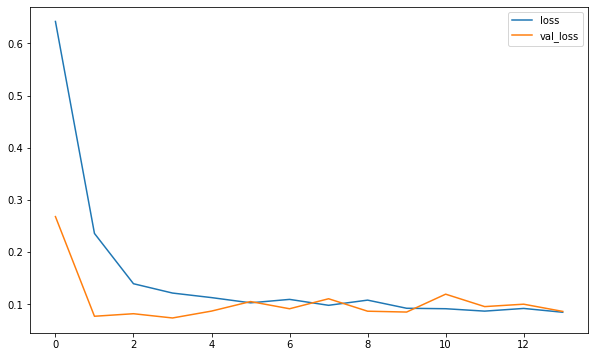

In [135]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [136]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)
y_pred = model.predict(validation_generator)
eval_metrics(test_scaled[12:], y_pred)

24/24 [==============================] - 0s 2ms/step
r2_score: 0.8828856951696515 
 mae: 0.23965969322417355 
 mse: 0.08587317933365742 
 rmse: 0.29304125875660825


In [137]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)
    
eval_metrics(test_scaled, test_predictions)

1/1 [==============================] - 0s 15ms/step
r2_score: 0.8897049424561516 
 mae: 0.22248696897805237 
 mse: 0.07952574129977914 
 rmse: 0.2820030873940552


#### Inverse Transformations and Comparing

In [138]:
true_predictions = scaler.inverse_transform(test_predictions)

In [139]:
test.head()

,amount
DATE,
2016-10-01,101.384
2016-11-01,86.665
2016-12-01,81.257
2017-01-01,94.245
2017-02-01,112.388


In [140]:
test['prediction'] = true_predictions

In [141]:
test

,amount,prediction
DATE,,
2016-10-01,101.384,96.678
2016-11-01,86.665,85.243
2016-12-01,81.257,79.475
2017-01-01,94.245,89.985
2017-02-01,112.388,101.427
2017-03-01,119.698,110.109
2017-04-01,123.228,115.701
2017-05-01,116.064,119.464
2017-06-01,123.087,121.718


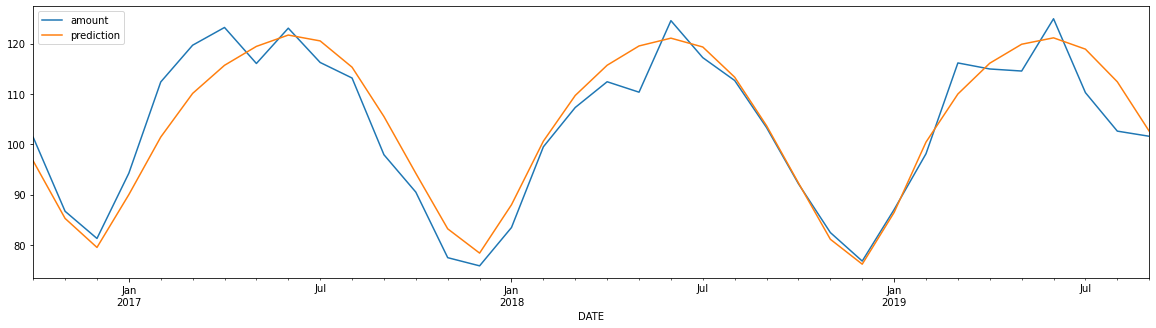

In [150]:
test.plot(figsize=(20,5));

#### Calculation R2 Score and Error Metrics

In [143]:
eval_metrics(test.amount, test.prediction)

r2_score: 0.8897049267915795 
 mae: 3.865347189670139 
 mse: 24.00355046933278 
 rmse: 4.899341840424363


## Retrain and Forecasting

In [144]:
test

,amount,prediction
DATE,,
2016-10-01,101.384,96.678
2016-11-01,86.665,85.243
2016-12-01,81.257,79.475
2017-01-01,94.245,89.985
2017-02-01,112.388,101.427
2017-03-01,119.698,110.109
2017-04-01,123.228,115.701
2017-05-01,116.064,119.464
2017-06-01,123.087,121.718


In [145]:
full_scaler = StandardScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [146]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [147]:
model = Sequential()

model.add(LSTM(54, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=64)

Epoch 1/64
105/105 [==============================] - 2s 4ms/step - loss: 0.5835
Epoch 2/64
105/105 [==============================] - 0s 4ms/step - loss: 0.1877
Epoch 3/64
105/105 [==============================] - 0s 4ms/step - loss: 0.1405
Epoch 4/64
105/105 [==============================] - 0s 4ms/step - loss: 0.1170
Epoch 5/64
105/105 [==============================] - 0s 4ms/step - loss: 0.1065
Epoch 6/64
105/105 [==============================] - 0s 4ms/step - loss: 0.1127
Epoch 7/64
105/105 [==============================] - 0s 4ms/step - loss: 0.1051
Epoch 8/64
105/105 [==============================] - 0s 4ms/step - loss: 0.1004
Epoch 9/64
105/105 [==============================] - 0s 4ms/step - loss: 0.1030
Epoch 10/64
105/105 [==============================] - 0s 4ms/step - loss: 0.0957
Epoch 11/64
105/105 [==============================] - 0s 4ms/step - loss: 0.0943
Epoch 12/64
105/105 [==============================] - 0s 4ms/step - loss: 0.0949
Epoch 13/64
105/105 [====

In [148]:
scaled_full_data.shape

(117, 1)

In [149]:
scaled_full_data[-length:].shape

(12, 1)

In [153]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:] 
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

1/1 [==============================] - 0s 16ms/step


In [154]:
forecast = scaler.inverse_transform(forecast)

In [155]:
forecast

array([[ 90.41806 ],
       [ 79.473366],
       [ 75.42434 ],
       [ 88.59626 ],
       [101.443665],
       [113.524895],
       [116.7968  ],
       [123.3216  ],
       [127.03812 ],
       [122.51857 ],
       [117.0572  ],
       [108.393524]], dtype=float32)

In [156]:
df.head()

,amount
DATE,
2010-01-01,91.290
2010-02-01,110.499
2010-03-01,127.097
2010-04-01,132.647
2010-05-01,134.558


In [157]:
forecast_index = pd.date_range(start = '2019-10-01', periods = periods, freq = 'MS')

In [158]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [159]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['forecast'])

In [160]:
forecast_df

,forecast
2019-10-01,90.418
2019-11-01,79.473
2019-12-01,75.424
2020-01-01,88.596
2020-02-01,101.444
2020-03-01,113.525
2020-04-01,116.797
2020-05-01,123.322
2020-06-01,127.038
2020-07-01,122.519


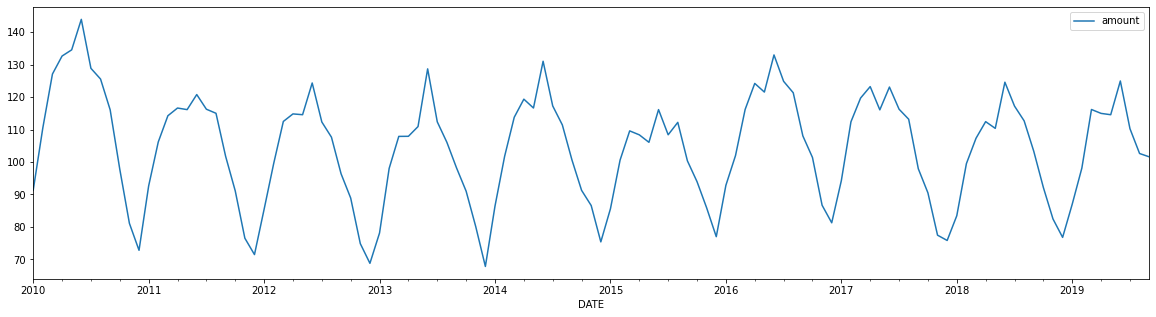

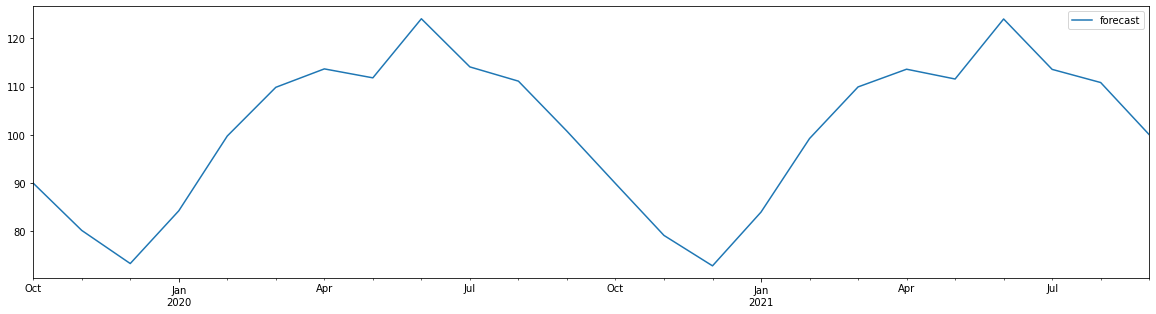

In [154]:
df.plot(figsize=(20,5));
forecast_df.plot(figsize=(20,5));

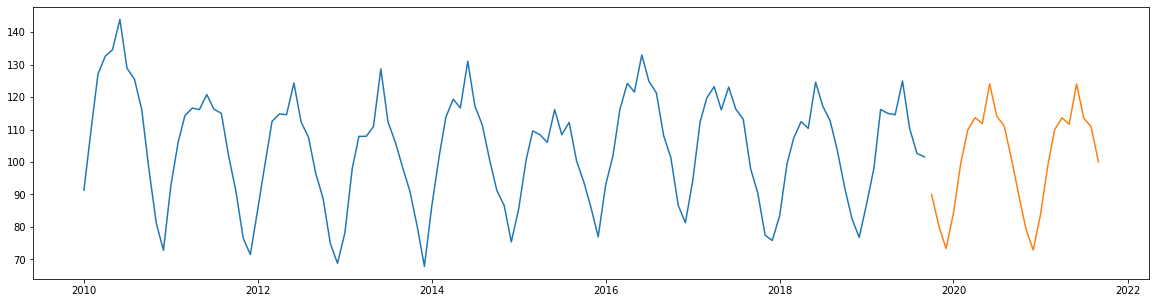

In [155]:
plt.figure(figsize = (20, 5))
plt.plot(df.index, df['amount'])
plt.plot(forecast_df.index, forecast_df['forecast']);
#plt.plot(forecast_index, forecast)

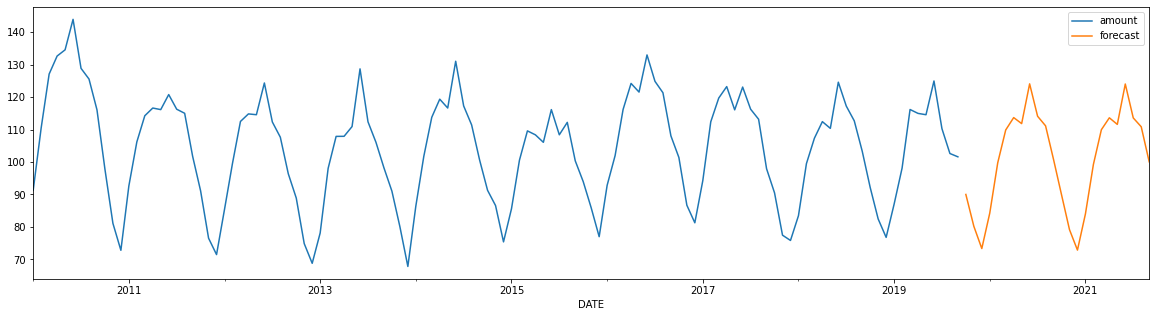

In [156]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (20, 5));